In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

import seaborn as sns # import seaborn for plotting
import matplotlib.pyplot as plt # import matplotlib for plotting

In [3]:

# Load the dataset
data = pd.read_csv('/content/mbti_1.csv')  # Adjust the path as needed

In [4]:
data.shape

(8675, 2)

In [5]:
# Display last five entries of data

data.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [6]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [7]:
# Show the information of data to find any null value

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [8]:
# Show the statistical summary of data

data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


<ipython-input-9-e110ac3ec858>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=data, order=data['type'].value_counts().index, palette="viridis")


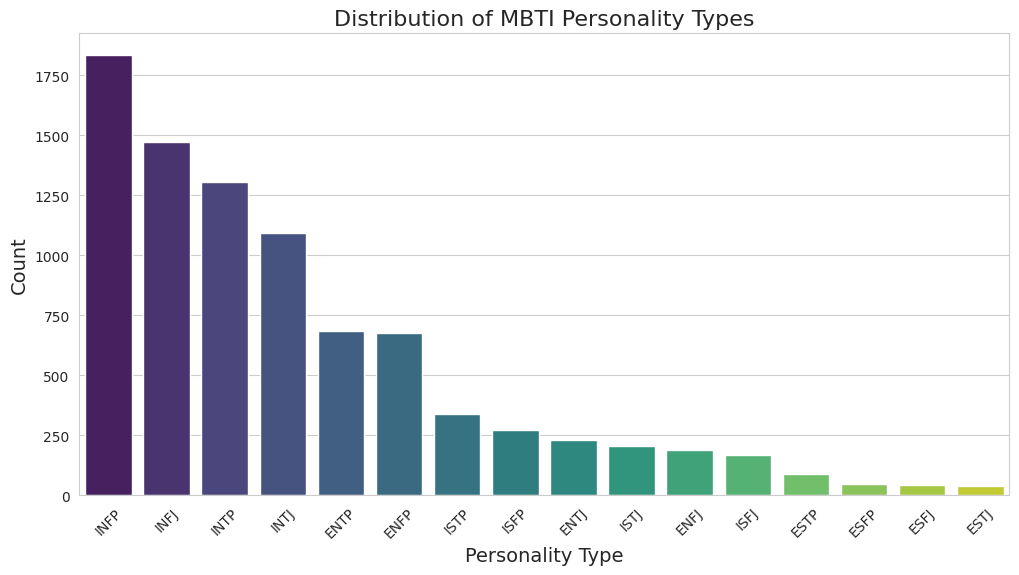

In [9]:
# Set plot size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create a count plot of MBTI personality types
sns.countplot(x='type', data=data, order=data['type'].value_counts().index, palette="viridis")

# Set plot labels and title
plt.title("Distribution of MBTI Personality Types", fontsize=16)
plt.xlabel("Personality Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()

<ipython-input-10-06b3d825f7ff>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data['type_num'], kde=False, bins=len(mbti_mapping), palette="viridis", discrete=True)


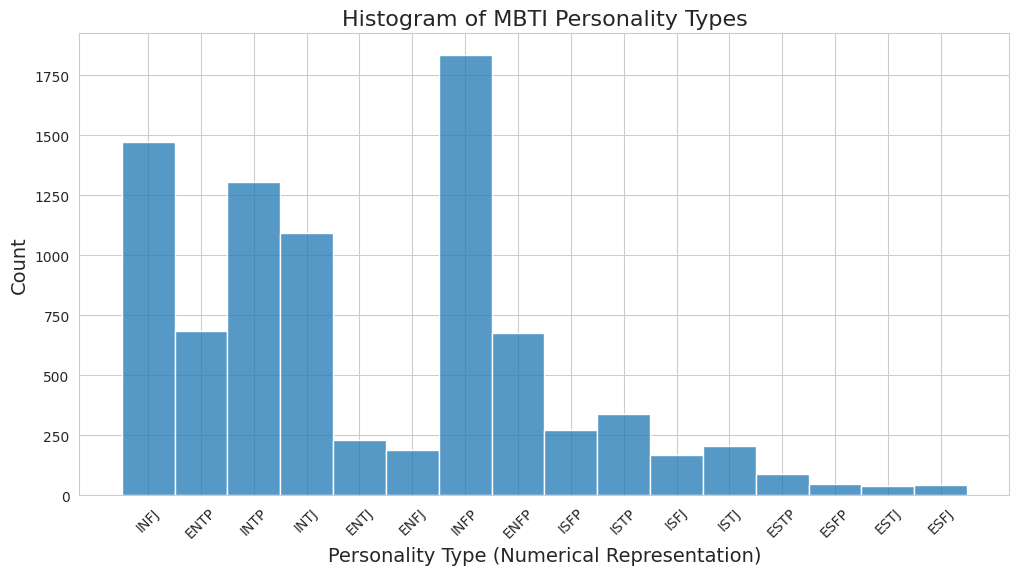

In [10]:
# Map MBTI types to numerical values for histogram visualization
# Each MBTI type is assigned an integer value for plotting
mbti_mapping = {type_: idx for idx, type_ in enumerate(data['type'].unique())}
data['type_num'] = data['type'].map(mbti_mapping)

# Set plot size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create a histogram of MBTI types (numerical representation)
sns.histplot(data['type_num'], kde=False, bins=len(mbti_mapping), palette="viridis", discrete=True)

# Set plot labels and title
plt.title("Histogram of MBTI Personality Types", fontsize=16)
plt.xlabel("Personality Type (Numerical Representation)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=range(len(mbti_mapping)), labels=mbti_mapping.keys(), rotation=45)
plt.show()

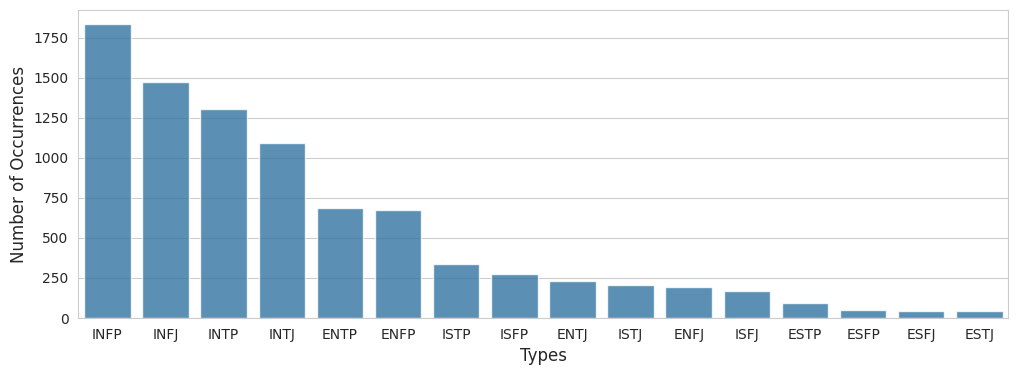

In [11]:
cnt_srs = data['type'].value_counts() # Replace train with data
plt.figure(figsize = (12, 4))
# Pass x and y as keyword arguments to barplot
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha = 0.8)
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Types', fontsize = 12)
plt.show()

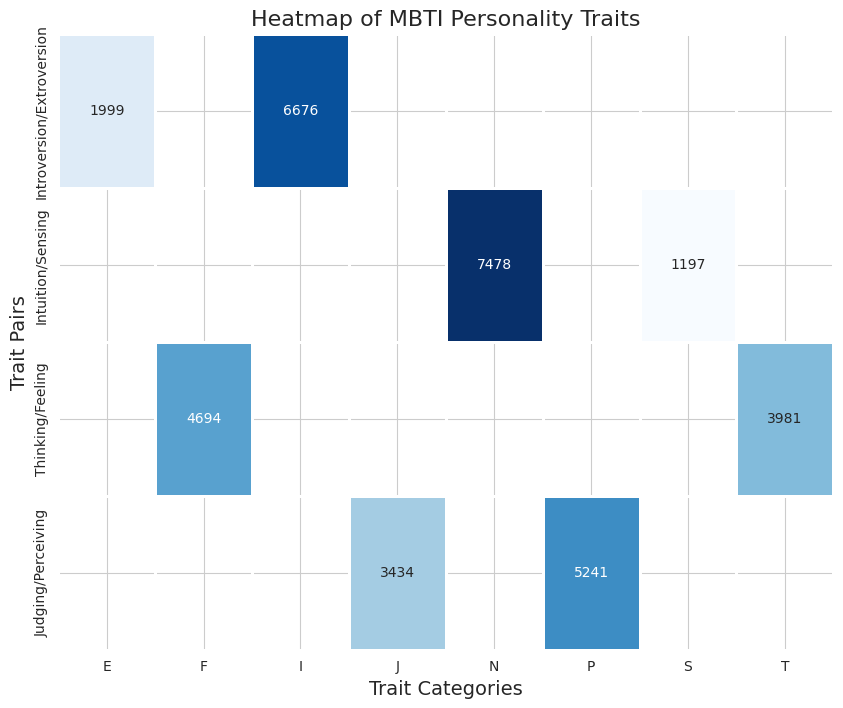

In [12]:
# Create separate columns for each of the MBTI traits
data['I_E'] = data['type'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
data['N_S'] = data['type'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
data['T_F'] = data['type'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
data['J_P'] = data['type'].apply(lambda x: 'J' if x[3] == 'J' else 'P')

# Create a DataFrame to count occurrences of each combination of traits
trait_counts = pd.DataFrame({
    'Introversion/Extroversion': data['I_E'].value_counts(),
    'Intuition/Sensing': data['N_S'].value_counts(),
    'Thinking/Feeling': data['T_F'].value_counts(),
    'Judging/Perceiving': data['J_P'].value_counts(),
}).T  # Transpose to align traits as rows and columns

# Set plot size and style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Create a heatmap of the trait counts
# Use '.0f' to format annotations as integers with no decimal places
sns.heatmap(trait_counts, annot=True, cmap='Blues', fmt='.0f', cbar=False, linewidths=1)

# Set plot labels and title
plt.title("Heatmap of MBTI Personality Traits", fontsize=16)
plt.ylabel("Trait Pairs", fontsize=14)
plt.xlabel("Trait Categories", fontsize=14)
plt.show()

In [14]:
# Data preprocessing
data['posts'] = data['posts'].apply(lambda x: re.sub(r'http\S+', '', x))  # Remove URLs
data['posts'] = data['posts'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove special characters
data['posts'] = data['posts'].str.lower()  # Convert to lowercase

In [16]:
# Splitting data
X = data['posts']
y = data['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Define Pipeline with TF-IDF, SVD for dimensionality reduction, and classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('svd', TruncatedSVD(n_components=100)),
    ('classifier', ExtraTreesClassifier(n_estimators=100, random_state=42))
])

In [19]:

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('svd', TruncatedSVD(n_components=100)),
                ('classifier', ExtraTreesClassifier(random_state=42))])

In [21]:

# Evaluate the model
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5844380403458214
              precision    recall  f1-score   support

        ENFJ       0.44      0.10      0.16        41
        ENFP       0.76      0.46      0.57       125
        ENTJ       0.80      0.27      0.41        44
        ENTP       0.63      0.46      0.53       135
        ESFJ       0.00      0.00      0.00         7
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00         7
        ESTP       1.00      0.07      0.12        15
        INFJ       0.55      0.64      0.59       288
        INFP       0.50      0.85      0.63       370
        INTJ       0.61      0.63      0.62       193
        INTP       0.67      0.74      0.70       293
        ISFJ       0.89      0.18      0.30        45
        ISFP       0.62      0.09      0.16        53
        ISTJ       0.67      0.09      0.16        44
        ISTP       0.77      0.34      0.47        67

    accuracy                           0.58      17

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


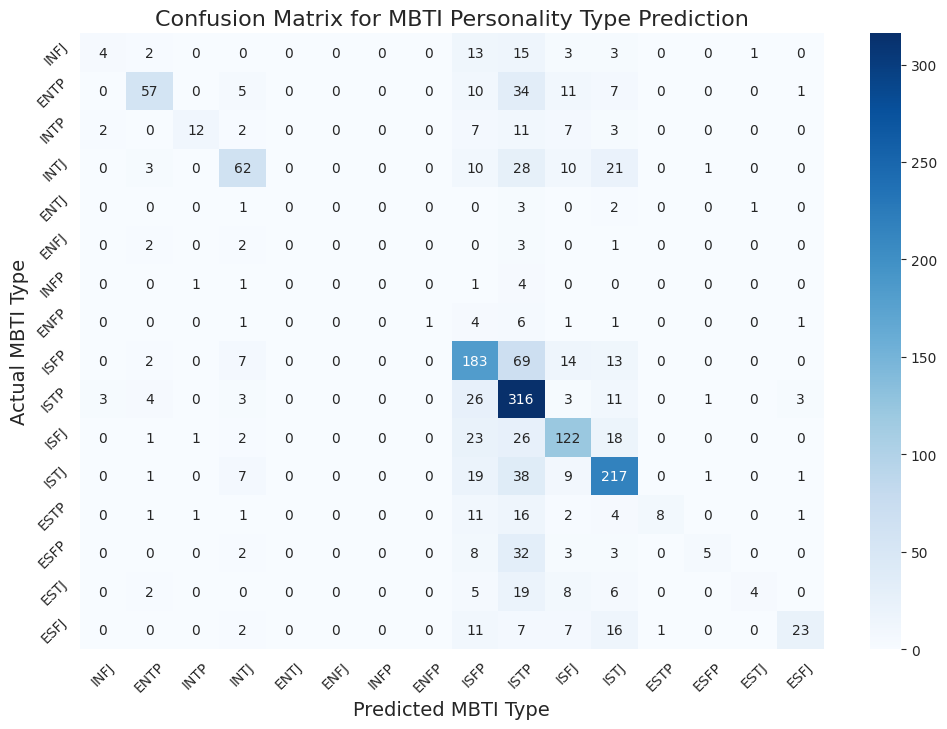

In [23]:

# Import the confusion_matrix function from sklearn.metrics
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())

# Set labels and title
plt.title("Confusion Matrix for MBTI Personality Type Prediction", fontsize=16)
plt.xlabel("Predicted MBTI Type", fontsize=14)
plt.ylabel("Actual MBTI Type", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [24]:
# Define personality characteristics for each MBTI letter
personality_traits = {
    'I': "Introversion: Focused on inner thoughts and ideas rather than external stimulation.",
    'E': "Extroversion: Draws energy from social interactions and external activities.",
    'N': "Intuition: Prefers abstract concepts and future possibilities.",
    'S': "Sensing: Focuses on concrete information and present realities.",
    'T': "Thinking: Makes decisions based on logic and objective analysis.",
    'F': "Feeling: Makes decisions based on personal values and emotions.",
    'J': "Judging: Prefers structure, planning, and decisiveness.",
    'P': "Perceiving: Prefers flexibility, spontaneity, and adaptability."
}

In [25]:

# Function to make predictions on new input and show detailed personality characteristics
def predict_personality(text):
    # Preprocess the input text
    processed_text = re.sub(r'http\S+', '', text)  # Remove URLs
    processed_text = re.sub(r'[^\w\s]', '', processed_text)  # Remove special characters
    processed_text = processed_text.lower()  # Convert to lowercase

    # Predict MBTI type
    prediction = pipeline.predict([processed_text])[0]

    # Display the prediction and detailed personality traits
    print(f"Predicted MBTI Type: {prediction}")
    print("Personality Characteristics:")
    for letter in prediction:
        print(f"- {personality_traits[letter]}")

    return prediction

In [26]:
# Test the model with a sample input
sample_text = "I enjoy spending time alone, reflecting on my thoughts and ideas."
predicted_type = predict_personality(sample_text)

Predicted MBTI Type: INFJ
Personality Characteristics:
- Introversion: Focused on inner thoughts and ideas rather than external stimulation.
- Intuition: Prefers abstract concepts and future possibilities.
- Feeling: Makes decisions based on personal values and emotions.
- Judging: Prefers structure, planning, and decisiveness.


In [27]:
sample_text_1 = "I love meeting new people and often feel energized after spending time in large groups. I enjoy trying new things and focusing on practical solutions."
predicted_type_1 = predict_personality(sample_text_1)


Predicted MBTI Type: INFP
Personality Characteristics:
- Introversion: Focused on inner thoughts and ideas rather than external stimulation.
- Intuition: Prefers abstract concepts and future possibilities.
- Feeling: Makes decisions based on personal values and emotions.
- Perceiving: Prefers flexibility, spontaneity, and adaptability.


In [28]:
sample_text_2 = "I often find myself deep in thought, thinking about abstract ideas and future possibilities. I like to plan things out and value logical decision-making."
predicted_type_2 = predict_personality(sample_text_2)


Predicted MBTI Type: INTP
Personality Characteristics:
- Introversion: Focused on inner thoughts and ideas rather than external stimulation.
- Intuition: Prefers abstract concepts and future possibilities.
- Thinking: Makes decisions based on logic and objective analysis.
- Perceiving: Prefers flexibility, spontaneity, and adaptability.


In [29]:
sample_text_3 = "I am very empathetic and enjoy connecting with others on an emotional level. I often make decisions based on how it might impact those around me."
predicted_type_3 = predict_personality(sample_text_3)


Predicted MBTI Type: INTP
Personality Characteristics:
- Introversion: Focused on inner thoughts and ideas rather than external stimulation.
- Intuition: Prefers abstract concepts and future possibilities.
- Thinking: Makes decisions based on logic and objective analysis.
- Perceiving: Prefers flexibility, spontaneity, and adaptability.


In [30]:
sample_text_4 = "I prefer clear guidelines and like to have a structured plan for my projects. I enjoy working alone to focus on my own ideas and believe logic is key to success."
predicted_type_4 = predict_personality(sample_text_4)


Predicted MBTI Type: INTJ
Personality Characteristics:
- Introversion: Focused on inner thoughts and ideas rather than external stimulation.
- Intuition: Prefers abstract concepts and future possibilities.
- Thinking: Makes decisions based on logic and objective analysis.
- Judging: Prefers structure, planning, and decisiveness.


In [31]:
sample_text_5 = "I enjoy brainstorming with others and thinking about big-picture ideas. I’m more focused on potential possibilities than on current details."
predicted_type_5 = predict_personality(sample_text_5)


Predicted MBTI Type: INTP
Personality Characteristics:
- Introversion: Focused on inner thoughts and ideas rather than external stimulation.
- Intuition: Prefers abstract concepts and future possibilities.
- Thinking: Makes decisions based on logic and objective analysis.
- Perceiving: Prefers flexibility, spontaneity, and adaptability.


In [32]:
sample_text_6 = "I like to spent time with people who are extrovert and making so many fun."
predicted_type_6 = predict_personality(sample_text_5)


Predicted MBTI Type: INTP
Personality Characteristics:
- Introversion: Focused on inner thoughts and ideas rather than external stimulation.
- Intuition: Prefers abstract concepts and future possibilities.
- Thinking: Makes decisions based on logic and objective analysis.
- Perceiving: Prefers flexibility, spontaneity, and adaptability.
